In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [9]:
from gym_stock_trading_env import StockTradingEnv

In [10]:
def custom_render(env):
    """
    Visualizes the stock price over time and marks buy/sell transactions.
    """
    clear_output(wait=True)
    plt.figure(figsize=(12, 6))
    
    # Plot the closing prices up to the current step
    plt.plot(env.df['Close'][:env.current_step+1], label='Close Price')
    
    # Mark the current price
    current_price = env.df['Close'].iloc[env.current_step]
    plt.scatter(env.current_step, current_price, color='red', marker='o', s=100, label='Current Price')
    
    # Separate trade history for buys and sells
    buys = [trade for trade in env.trade_history if trade['action'] == 1]
    sells = [trade for trade in env.trade_history if trade['action'] == 2]
    
    if buys:
        buy_steps = [trade['step'] for trade in buys]
        buy_prices = [trade['price'] for trade in buys]
        plt.scatter(buy_steps, buy_prices, color='green', marker='^', s=100, label='Buy')
        
    if sells:
        sell_steps = [trade['step'] for trade in sells]
        sell_prices = [trade['price'] for trade in sells]
        plt.scatter(sell_steps, sell_prices, color='black', marker='v', s=100, label='Sell')
    
    plt.title(f"Step: {env.current_step} | Total Asset: {env.total_asset_value:.2f}")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

In [11]:
df = yf.download("RHM.DE", start="2020-01-01", end="2023-01-01")
df.head(6)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,RHM.DE,RHM.DE,RHM.DE,RHM.DE,RHM.DE
Date,,,,,
2020-01-02,93.279602,93.459763,91.613085,92.243661,61472
2020-01-03,92.739105,92.874229,91.703171,92.288697,77883
2020-01-06,91.432922,92.153579,90.982514,92.063491,93166
2020-01-07,93.189522,93.684974,91.973420,91.973420,93721
2020-01-08,93.504807,93.730011,92.423822,92.784150,52043
2020-01-09,94.045303,94.630836,93.730019,94.000260,61681


In [12]:
class PercentChangeStrategy:
    def __init__(self, threshold_down=0.95, threshold_up=1.10, initial_reference=None):
        """
        Parameters:
        -----------
        threshold_down : float
            The multiplier for a down move (e.g., 0.95 means a 5% drop).
        threshold_up : float
            The multiplier for an up move (e.g., 1.10 means a 10% increase).
        initial_reference : float or None
            If None, the reference price will be initialized to the first observed price.
        """
        self.threshold_down = threshold_down
        self.threshold_up = threshold_up
        self.reference_price = initial_reference

    def get_action(self, env):
        """
        Decide an action based on the current price relative to a reference price.
        
        Returns:
            0 (Hold), 1 (Buy), or 2 (Sell)
        """
        current_price = float(env.df.loc[env.current_step, 'Close'])
        
        # Initialize reference price if not set.
        if self.reference_price is None:
            self.reference_price = current_price
        
        # If holding a position, sell only if the price has increased sufficiently.
        if env.num_shares > 0:
            if current_price >= self.reference_price * self.threshold_up:
                # Update the reference price on sale.
                self.reference_price = current_price
                return 2  # Sell
            else:
                return 0  # Hold
        
        # If not holding, buy only if the price has dropped sufficiently.
        else:
            if current_price <= self.reference_price * self.threshold_down:
                # Update the reference price on purchase.
                self.reference_price = current_price
                return 1  # Buy
            else:
                return 0  # Hold


In [ ]:

def strategy_extrema(env, window=10 ):
    """
    Strategy 2: Extrema Detection Strategy
    ----------------------------------------
    - Looks at the closing prices over the last 'window' steps (including the current step).
    - If the current price is the lowest in that window, it returns a Buy (1).
    - If the current price is the highest in that window, it returns a Sell (2).
    - Otherwise, it holds (0).
    """
    # If not enough data points, just hold.
    if env.current_step < window:
        return 0  
    # Get the window of past prices, including the current step.
    window_prices = env.df['Close'].iloc[env.current_step - window: env.current_step + 1].values
    current_price = float(env.df.loc[env.current_step, 'Close'])
    
    # Buy if current price is the minimum, sell if maximum.
    if current_price <= window_prices.min():
        return 1  # Buy
    elif current_price >= window_prices.max():
        return 2  # Sell
    else:
        return 0  # Hold


In [ ]:
env = StockTradingEnv(df, initial_balance=10000, custom_render=custom_render)

c:\Users\mikol\OneDrive\Pulpit\Projekty_prywatne\Stock-trading-Reinforcement-Learning\gym_stock_trading_env.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(self.df.loc[self.current_step, 'Close'])


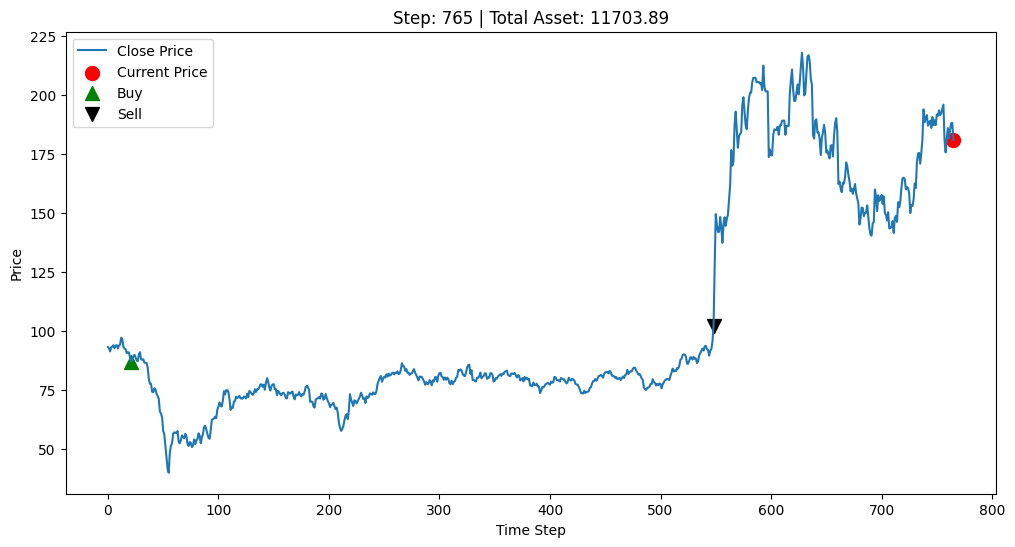


Episode finished after 765 steps!


In [ ]:
# Instantiate the percent change strategy.
percent_strategy = PercentChangeStrategy()

done = False
step_counter = 0
while not done:
    # Get an action from the percent change strategy.
    action = percent_strategy.get_action(env)
    obs, reward, done, info = env.step(action)
    env.render()
    step_counter += 1

print(f"\nEpisode finished after {step_counter} steps!")


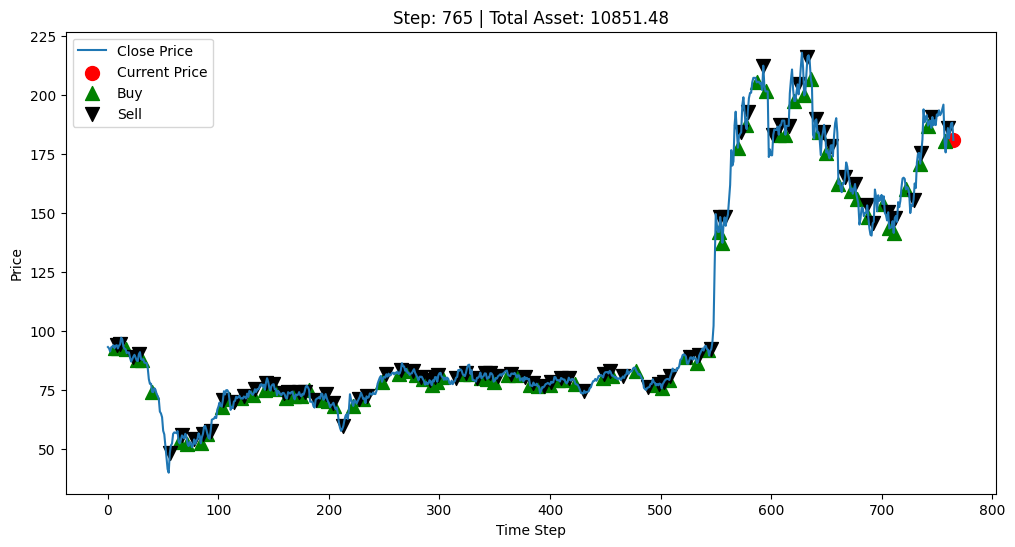


Episode finished after 765 steps!


In [ ]:
#run strategy buy on local minimas sell on maximas, leftward derrivative calculation on smoothed out window
obs = env.reset()
done = False
step_counter = 0
while not done:
    action = strategy_extrema(env, window=3)  
    obs, reward, done, info = env.step(action)
    env.render()  
    step_counter += 1

print(f"\nEpisode finished after {step_counter} steps!")